In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [3]:
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

In [4]:
k_ = gaussKernel(sigma=1)
ave_low_list = []
ave_high_list = []
p_mat = []
fish_id = []

for ind, row in dat_xls_file.iterrows():    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    task_period = _['task_period'] 
    swim_starts = _['swim_starts'] 
    trial_valid = np.ones(len(swim_starts)).astype('bool')
    for n, n_swim in enumerate(swim_starts[:-1]):        
        # examine the swim with short inter-swim-interval
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid[n] = False
    
               
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    # trial_valid = _['trial_valid']
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    
    for n_cell in range(sub_swim.shape[0]):
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        non_trial = np.isnan(spk_list).sum(axis=-1)==0
        trial_valid = trial_valid & non_trial
        # if np.isnan(spk_list[(task_period==1) & trial_valid].mean(axis=0)).sum()==0 and np.isnan(spk_list[(task_period==2) & trial_valid].mean(axis=0)).sum()==0:
        gain_stat = np.zeros(t_pre+t_post)
        for ntime in range(-t_pre, t_post):
            val, pval= ranksums(spk_list[(task_period==1) & trial_valid, t_pre+ntime], 
                                spk_list[(task_period==2) & trial_valid, t_pre+ntime])
            gain_stat[t_pre+ntime] = np.sign(-val) * pval
        p_mat.append(gain_stat)
        ave_low_list.append(spk_list[(task_period==1) & trial_valid].mean(axis=0)*300)
        ave_high_list.append(spk_list[(task_period==2) & trial_valid].mean(axis=0)*300)
        fish_id.append(folder+fish[:5])

# print number of fish
len(np.unique(np.array(fish_id)))

18

In [5]:
nan_line_wid = 3
nan_line = np.empty((len(ave_low_list), nan_line_wid))
nan_line[:] = np.nan
ave_list = np.concatenate([np.array(ave_low_list), nan_line, np.array(ave_high_list)], axis=-1)
ave_list_min = np.nanmin(ave_list, axis=-1, keepdims=True)
ave_list_max = np.nanmax(ave_list, axis=-1, keepdims=True)
valid = (ave_list_max - ave_list_min) >0
ave_list = (ave_list - ave_list_min)/(ave_list_max - ave_list_min)

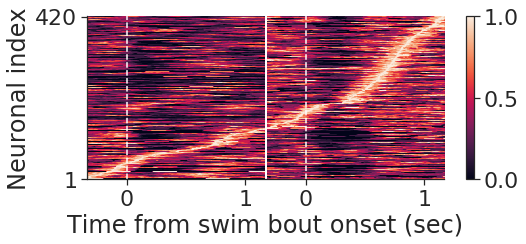

In [6]:
ave_list_ = ave_list[valid[:,0], :]
max_ind = np.nanargmax(ave_list_, axis=-1)
sort_max_ind = np.argsort(max_ind)
plt.figure(figsize=(8, 3))
plt.imshow(ave_list_[sort_max_ind, :], aspect='auto', origin='lower')
plt.vlines([t_pre, t_pre*2+t_post+nan_line_wid], [0], [len(sort_max_ind)], linestyles='--', colors='w')
plt.ylim([0, len(sort_max_ind)])
plt.ylabel('Neuronal index')
plt.xlabel('Time from swim bout onset (sec)')
plt.xticks([t_pre, t_pre+300, t_pre*2+t_post+nan_line_wid, t_pre*2+t_post+300+nan_line_wid], ['0', '1', '0', '1'])
plt.yticks([0, len(sort_max_ind)-1], [1, len(sort_max_ind)])
plt.colorbar()
sns.despine()
# plt.savefig('../Plots/gain/pop_act_max.pdf')

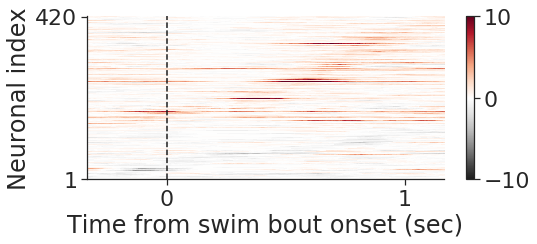

In [7]:
# sig_mat = np.abs(p_mat)<0.05
# sel_ind = sig_mat.sum(axis=-1)>30
# p_mat = p_mat[sel_ind]
sig_mat = -np.log(np.abs(p_mat)+1e-10)
sign_mat = np.sign(p_mat)
# ind = np.argmax(sig_mat, axis=-1)
# sign_ind = np.median(sign_mat, axis=-1)
# ind = np.lexsort((ind, sign_ind))
sig_mat = sig_mat*sign_mat
# sig_mat[np.abs(sig_mat)<3] = 0
plt.figure(figsize=(8, 3))
plt.imshow(sig_mat[sort_max_ind, :], aspect='auto', origin='lower',cmap=plt.cm.RdGy_r, vmin=-10, vmax=10)
plt.vlines([t_pre], [0], [len(sort_max_ind)], linestyles='--', colors='k')
plt.ylim([0, len(sort_max_ind)])
plt.ylabel('Neuronal index')
plt.xlabel('Time from swim bout onset (sec)')
plt.xticks([t_pre, t_pre+300], ['0', '1'])
plt.yticks([0, len(sort_max_ind)-1], [1, len(sort_max_ind)])
plt.colorbar()
sns.despine()
# plt.savefig('../Plots/gain/pop_act_p_value.pdf')

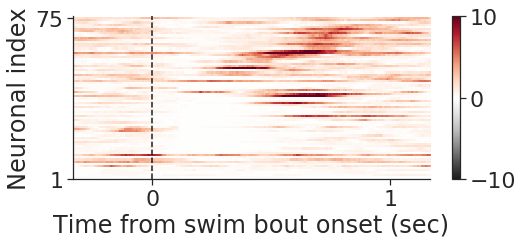

In [8]:
sig_mat = np.abs(p_mat)<0.05
sel_ind = sig_mat.sum(axis=-1)>30
p_mat_ = np.abs(p_mat)[sel_ind]
sig_mat = -np.log(np.abs(p_mat_)+1e-10)
sign_mat = np.sign(p_mat_)
ind = np.argmax(sig_mat, axis=-1)
sign_ind = np.median(sign_mat, axis=-1)
ind = np.lexsort((ind, sign_ind))
sig_mat = sig_mat*sign_mat
# sig_mat[np.abs(sig_mat)<3] = 0
plt.figure(figsize=(8, 3))
plt.imshow(sig_mat[ind], aspect='auto', origin='lower',cmap=plt.cm.RdGy_r, vmin=-10, vmax=10)
plt.vlines([t_pre], [0], [len(ind)], linestyles='--', colors='k')
plt.ylim([0, len(ind)])
plt.ylabel('Neuronal index')
plt.xlabel('Time from swim bout onset (sec)')
plt.xticks([t_pre, t_pre+300], ['0', '1'])
plt.yticks([0, len(ind)-1], [1, len(ind)])
plt.colorbar()
sns.despine()
# plt.savefig('../Plots/gain/pop_sel_act_p_value.pdf')

In [9]:
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = sig_mat.sum(axis=-1)>30

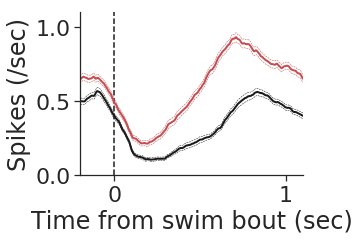

In [10]:
ave_act = np.array(ave_low_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_low_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_low_list))

plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)

ave_act = np.array(ave_high_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_high_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)

plt.vlines([0], [0], [1.1], linestyles='--', colors='k')
plt.xlim([-60/300, 330/300])
plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.01, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
# plt.savefig('../Plots/gain/pop_sel_act_ave.pdf')

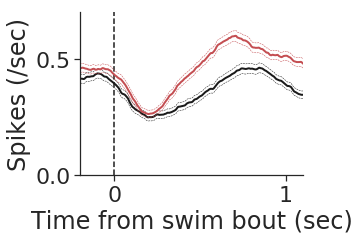

In [11]:
ave_act = np.array(ave_low_list).mean(axis=0)
sem_act = np.array(ave_low_list).std(axis=0)/np.sqrt(len(ave_low_list))

plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)

ave_act = np.array(ave_high_list).mean(axis=0)
sem_act = np.array(ave_high_list).std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)

plt.vlines([0], [0], [1.0], linestyles='--', colors='k')
plt.xlim([-60/300, 330/300])
plt.ylim([0, 0.7])
plt.yticks(np.arange(0, 1.0, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
# plt.savefig('../Plots/gain/pop_act_ave.pdf')

### plot example neurons

In [12]:
# k_ = gaussKernel(sigma=1)
# ave_low_list = []
# ave_high_list = []
# p_mat = []

# for ind, row in dat_xls_file.iterrows():    
#     folder = row['folder']
#     fish = row['fish']
#     task_type = row['task']
    
#     _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
#     task_period = _['task_period']   
#     swim_starts = _['swim_starts'] 
#     trial_valid = np.ones(len(swim_starts)).astype('bool')
#     for n, n_swim in enumerate(swim_starts[:-1]):        
#         # examine the swim with short inter-swim-interval
#         if swim_starts[n+1] - n_swim < t_sig:    
#             trial_valid[n] = False
#     _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
#     sub_swim = _['sub_swim']
#     spk_swim = _['spk_swim']
    
#     for n_cell in range(sub_swim.shape[0]):
#         spk_list = spk_swim[n_cell]
#         sub_list = sub_swim[n_cell]
#         sub_list = sub_list - sub_list[:, (t_pre-30):t_pre].mean(axis=-1, keepdims=True)
#         tmp = []
#         for n_spk in spk_list:
#             tmp.append(smooth(n_spk, k_))
#         spk_list = np.array(tmp)
#         gain_stat = np.zeros(t_pre+t_post)
#         for ntime in range(-t_pre, t_post):
#             val, pval= ranksums(spk_list[task_period==1, t_pre+ntime], 
#                                 spk_list[task_period==2, t_pre+ntime])
#             gain_stat[ntime] = np.sign(-val) * pval
#         sig_mat = np.abs(gain_stat)<0.05
#         if sig_mat.sum(axis=-1)<30:
#             continue
            
#         plt.plot(spk_list[(task_period==1) & trial_valid].mean(axis=0)*300)
#         plt.plot(spk_list[(task_period==2) & trial_valid].mean(axis=0)*300)
#         plt.title([ind, n_cell, folder, fish])
#         plt.show()
        
#         plt.plot(sub_list[(task_period==1) & trial_valid].mean(axis=0)*100)
#         plt.plot(sub_list[(task_period==2) & trial_valid].mean(axis=0)*100)
#         plt.title('subvolt')
#         plt.show()

In [13]:
dir_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'

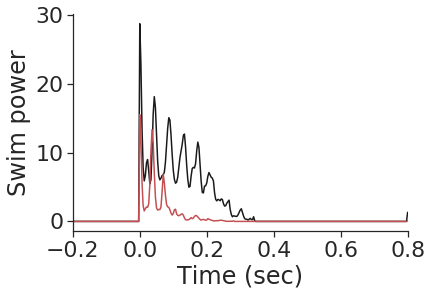

In [14]:
nfish = 1

row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
# print(f'Processing {folder} {fish}')
dat_dir = dir_folder+f'{folder}/{fish}/Data/'
swim_dir = dir_folder+f'{folder}/{fish}/swim/'
dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
num_cell = spk.shape[0]
# spk with padding zeros for the first 2 seconds
spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
frame_stimParams = np.load(swim_dir+'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir+'frame_swim_tcourse.npy')

_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

trial_valid = np.ones(len(swim_starts)).astype('bool')
for n, n_swim in enumerate(swim_starts[:-1]):        
    # examine the swim with short inter-swim-interval
    if swim_starts[n+1] - n_swim < t_sig:    
        trial_valid[n] = False


p_swim = np.sqrt(r_swim**2+l_swim**2)
plt.plot(t_label, p_swim[(task_period==1) & trial_valid, :].mean(axis=0), '-k')
plt.plot(t_label, p_swim[(task_period==2) & trial_valid, :].mean(axis=0), '-r')
plt.ylabel('Swim power')
plt.xlabel('Time (sec)')
plt.xlim([-0.2, 0.8])
sns.despine()
# plt.savefig('../Plots/gain/exp_neuron_swim.pdf')

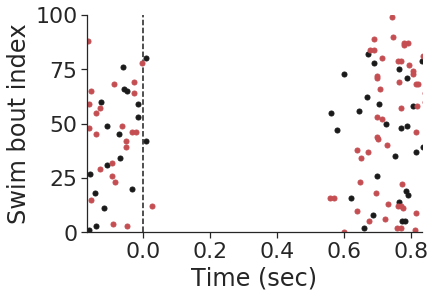

In [15]:
ncell_ = 19
spk_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300] 
        except:
            pass
    plt_raster(spk_list[(task_period==1) & trial_valid, :], c='k')
    plt_raster(spk_list[(task_period==2) & trial_valid, :], c='r')
    # plt.title(f'Cell #{n_cell}')
    plt.ylabel('Swim bout index')
    plt.xlabel('Time (sec)')
    plt.xlim([-50/300, 250/300])
    # plt.axis('off')
    plt.ylim([0, 100])
    plt.vlines([0], [0], [320], colors='k', linestyles='--')
    sns.despine()
#     plt.savefig('../Plots/gain/exp_neuron_raster.pdf')

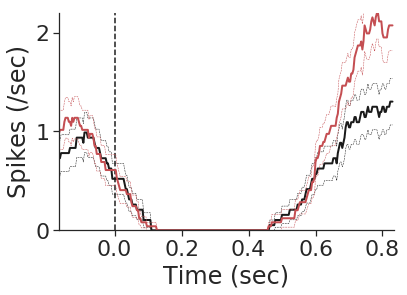

In [16]:
# k_ = gaussKernel(sigma=20)
k_ = boxcarKernel(sigma=60)
# ave_ = spk_list[task_period==1, :].mean(axis=0)*300
ave_ = []
for n_spk in spk_list[(task_period==1) & trial_valid, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-k', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--k', lw=0.5)


ave_ = []
for n_spk in spk_list[(task_period==2) & trial_valid, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-r', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--r', lw=0.5)

plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [0], [2.2], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()

# plt.savefig('../Plots/gain/exp_neuron_act.pdf')

In [17]:
from scipy.signal import medfilt

subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

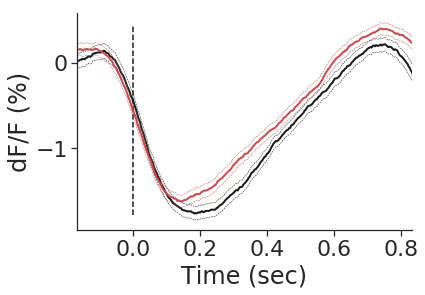

In [18]:
sub_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
        except:
            pass

t_min = 0
t_max = 400
ave_ = sub_list[(task_period==1) & trial_valid, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[50:(100-t_min)].mean()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-k', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--k', lw=0.5)

ave_ = sub_list[(task_period==2) & trial_valid, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[50:(100-t_min)].mean()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-r', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--r', lw=0.5)

# plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('dF/F (%)')
sns.despine()
# plt.savefig('../Plots/gain/exp_neuron_subvolt.pdf')